In [1]:
!mkdir -p ./kaggle
!cp kaggle(4).json ~/.kaggle/
!kaggle datasets download -d mostafaabla/garbage-classification
!unzip /content/garbage-classification.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/garbage_classification/paper/paper381.jpg  
  inflating: /content/garbage_classification/paper/paper382.jpg  
  inflating: /content/garbage_classification/paper/paper383.jpg  
  inflating: /content/garbage_classification/paper/paper384.jpg  
  inflating: /content/garbage_classification/paper/paper385.jpg  
  inflating: /content/garbage_classification/paper/paper386.jpg  
  inflating: /content/garbage_classification/paper/paper387.jpg  
  inflating: /content/garbage_classification/paper/paper388.jpg  
  inflating: /content/garbage_classification/paper/paper389.jpg  
  inflating: /content/garbage_classification/paper/paper39.jpg  
  inflating: /content/garbage_classification/paper/paper390.jpg  
  inflating: /content/garbage_classification/paper/paper391.jpg  
  inflating: /content/garbage_classification/paper/paper392.jpg  
  inflating: /content/garbage_classification/paper/paper393.jpg  
  inflating: /content/garb

##convert data folder  to test and  train folder..... data preprocessing ..

In [2]:
import os
import shutil
import random

# Define source and destination directories
source_dir = '/content/garbage_classification'  # Replace with your source directory
destination_dir = 'data'
train_dir = os.path.join(destination_dir, 'train')
test_dir = os.path.join(destination_dir, 'test')

# Create train and test directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Split ratio
train_ratio = 0.85

# Iterate through each class folder
for class_folder in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_folder)

    if os.path.isdir(class_path):
        # Create corresponding train/test folders
        os.makedirs(os.path.join(train_dir, class_folder), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_folder), exist_ok=True)

        # Get all images in the class folder
        images = os.listdir(class_path)
        random.shuffle(images)  # Shuffle the images for randomness

        # Split images into train and test sets
        split_index = int(len(images) * train_ratio)
        train_images = images[:split_index]
        test_images = images[split_index:]

        # Move images to respective folders
        for image in train_images:
            shutil.move(os.path.join(class_path, image), os.path.join(train_dir, class_folder, image))

        for image in test_images:
            shutil.move(os.path.join(class_path, image), os.path.join(test_dir, class_folder, image))

print("Data has been successfully split into train and test directories.")


Data has been successfully split into train and test directories.


##importing important libraries

In [3]:
import os
#importgting all imp library....
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

In [4]:

#specifying test and test data .......
train_data ='/content/data/train'
test_data ='/content/data/test'

batch_size =64

train_img_gen = ImageDataGenerator(rescale = 1./255,# Rescale pixel values to [0,1]
                                        rotation_range =10,
                                        zoom_range =0.2,
                                        brightness_range = None,
                                        width_shift_range =0.1,
                                        height_shift_range =0.1,
                                        horizontal_flip= True,
                                        fill_mode='nearest'
)


test_img_gen= ImageDataGenerator(rescale=1./255) # rescaleing to 0=1 range ....



#data genrator for train and test
train_genrator = train_img_gen.flow_from_directory(
    train_data, class_mode = 'categorical' , target_size = (224, 224) , color_mode = 'rgb',
    batch_size = batch_size, subset = 'training'
)


#for test data
test_genrator = test_img_gen.flow_from_directory(
    test_data , class_mode = 'categorical' , target_size = (224, 224) , color_mode = 'rgb',
    batch_size = batch_size

)

Found 13182 images belonging to 12 classes.
Found 2333 images belonging to 12 classes.


In [5]:
#getting resnet50 model .. for garbage classificaion ....
ResNet50V2_model = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False, # false  allow adding input and output layer...
                                               weights='imagenet'
                                               )

94668760/94668760 [==============================] - 0s 0us/step


Class Weights Dictionary: {0: 1.36799501867995, 1: 1.3124253285543608, 2: 2.133009708737864, 3: 1.45112285336856, 4: 0.24270879363676537, 5: 2.0571161048689137, 6: 1.6822358346094946, 7: 1.2315022421524664, 8: 1.4945578231292518, 9: 0.6538690476190476, 10: 1.8555743243243243, 11: 1.669452887537994}


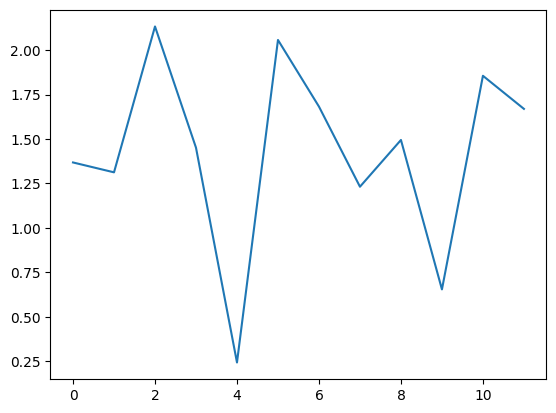

In [6]:
#extract class labels in training
classes = np.array(train_genrator.classes)
 # Strategy to balance classes
class_weight =compute_class_weight(
    class_weight= 'balanced',  # i crete class weight to handle imbalanced data ...
    classes = np.unique(classes), # Unique class labels
    y = classes# Class labels for each instance in the training dataset
)
class_dict = dict(enumerate(class_weight))
print("Class Weights Dictionary:", class_dict)

plt.plot(class_weight)

##Resnet model building

In [7]:

#now in resnet we freeze layers except last 50
ResNet50V2_model.trainable = True

for layer in ResNet50V2_model.layers[:-50]:
    layer.trainable = False

In [13]:

#resnet 50 model .... creating ...
model = Sequential([
                      ResNet50V2_model,
                      Dropout(0.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(0.5),
                      Dense(12,activation='softmax')
                    ]
                   )
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 dropout_2 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 batch_normalization_2 (Bat  (None, 7, 7, 2048)        8192      
 chNormalization)                                                
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 64)                6422592   
                                                                 
 batch_normalization_3 (Bat  (None, 64)                256       
 chNormalization)                                     

In [14]:
model.compile(optimizer = 'adam' , loss ='categorical_crossentropy' , metrics = 'accuracy')

In [15]:
path_cnn = '/content/garbage-detection/ResNet50_Transfer_Learning'
name = 'model_wirh_resnet50'
join_path = os.path.join(path_cnn, name)
#callbacks to check model setpionts

checkpoint_callbacks = ModelCheckpoint(filepath = join_path , verbose = 1,
                                       mode = 'min', save_best_only = True,
                                        monitor= 'val_loss')

earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 7,
                          restore_best_weights = True,
                          verbose=1)
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
                              verbose=1)
#call back for csv logger
csv_logger = CSVLogger(os.path.join(path_cnn,'training.log'))# Callback to log training data to a CSV file


In [16]:
# load all callbacks into a list
callbacks = [checkpoint_callbacks, earlystop, csv_logger]

train_steps_per_epoch = train_genrator.samples // train_genrator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_genrator.samples // test_genrator.batch_size + 1


print(train_steps_per_epoch)
print(test_steps_epoch)

206
37


In [17]:

train_history = model.fit(
                          train_genrator,
                          steps_per_epoch=train_steps_per_epoch,
                          epochs=5,
                          validation_data=test_genrator,
                          validation_steps=test_steps_epoch,
                          class_weight=class_dict,
                          callbacks = callbacks
                         )

Epoch 1/5
206/206 [==============================] - ETA: 0s - loss: 0.9412 - accuracy: 0.7670
Epoch 1: val_loss improved from inf to 0.88011, saving model to /content/garbage-detection/ResNet50_Transfer_Learning/model_wirh_resnet50
206/206 [==============================] - 336s 2s/step - loss: 0.9412 - accuracy: 0.7670 - val_loss: 0.8801 - val_accuracy: 0.7754
Epoch 2/5
206/206 [==============================] - ETA: 0s - loss: 0.5132 - accuracy: 0.8820
Epoch 2: val_loss improved from 0.88011 to 0.30377, saving model to /content/garbage-detection/ResNet50_Transfer_Learning/model_wirh_resnet50
206/206 [==============================] - 329s 2s/step - loss: 0.5132 - accuracy: 0.8820 - val_loss: 0.3038 - val_accuracy: 0.9078
Epoch 3/5
206/206 [==============================] - ETA: 0s - loss: 0.3814 - accuracy: 0.9082
Epoch 3: val_loss did not improve from 0.30377
206/206 [==============================] - 308s 1s/step - loss: 0.3814 - accuracy: 0.9082 - val_loss: 0.6531 - val_accuracy:

In [18]:
model.save("emotion_model.keras")

In [22]:
model.save("garbage-classification.keras")

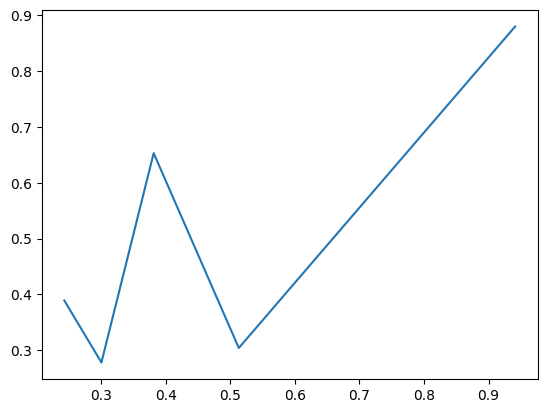

In [23]:
import keras


loss = train_history.history['loss']
val_accuracy = train_history.history['val_loss']

plt.plot(loss, val_accuracy)
plt.show()

In [24]:
take = keras.saving.load_model('/content/garbage-classification.keras')

In [25]:
train_history = take.fit(
    train_genrator, steps_per_epoch=train_steps_per_epoch,
                          epochs=5,
                          validation_data=test_genrator,
                          validation_steps=test_steps_epoch,
                          class_weight=class_dict,
                          callbacks = callbacks
                         )

Epoch 1/5
206/206 [==============================] - ETA: 0s - loss: 0.1926 - accuracy: 0.9489
Epoch 1: val_loss improved from 0.27778 to 0.25562, saving model to /content/garbage-detection/ResNet50_Transfer_Learning/model_wirh_resnet50
206/206 [==============================] - 338s 2s/step - loss: 0.1926 - accuracy: 0.9489 - val_loss: 0.2556 - val_accuracy: 0.9276
Epoch 2/5
206/206 [==============================] - ETA: 0s - loss: 0.1855 - accuracy: 0.9509
Epoch 2: val_loss did not improve from 0.25562
206/206 [==============================] - 303s 1s/step - loss: 0.1855 - accuracy: 0.9509 - val_loss: 0.2729 - val_accuracy: 0.9220
Epoch 3/5
206/206 [==============================] - ETA: 0s - loss: 0.1785 - accuracy: 0.9527
Epoch 3: val_loss improved from 0.25562 to 0.19280, saving model to /content/garbage-detection/ResNet50_Transfer_Learning/model_wirh_resnet50
206/206 [==============================] - 317s 2s/step - loss: 0.1785 - accuracy: 0.9527 - val_loss: 0.1928 - val_accur

In [26]:
test_loss, test_accu = model.evaluate(test_genrator)
print(test_loss, test_accu)

37/37 [==============================] - 28s 746ms/step - loss: 0.3890 - accuracy: 0.8937
0.3890012204647064 0.8936991095542908


In [27]:
#now print ..... final printing train and test accuracy
train_loss, train_accu = model.evaluate(train_genrator)
test_loss, test_accu = model.evaluate(test_genrator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

37/37 [==============================] - 29s 769ms/step - loss: 0.3890 - accuracy: 0.8937
final train accuracy = 91.81 , validation accuracy = 89.37


In [28]:
#im here assuming true class and pridected class .....ive  alredy defined
true_classes = test_genrator.classes
predicted_classes = np.argmax(model.predict(test_genrator, steps=np.ceil(test_genrator.samples/test_genrator.batch_size)), axis=1)
class_labels = list(test_genrator.class_indices.keys())

37/37 [==============================] - 30s 771ms/step


In [29]:
# Printing  classification report...understaing model performance
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

     battery       0.03      0.03      0.03       142
  biological       0.05      0.05      0.05       148
 brown-glass       0.03      0.07      0.04        92
   cardboard       0.05      0.04      0.05       134
     clothes       0.33      0.31      0.32       799
 green-glass       0.07      0.06      0.07        95
       metal       0.06      0.08      0.07       116
       paper       0.08      0.08      0.08       158
     plastic       0.07      0.06      0.07       130
       shoes       0.15      0.15      0.15       297
       trash       0.07      0.07      0.07       105
 white-glass       0.05      0.03      0.04       117

    accuracy                           0.16      2333
   macro avg       0.09      0.09      0.09      2333
weighted avg       0.16      0.16      0.16      2333



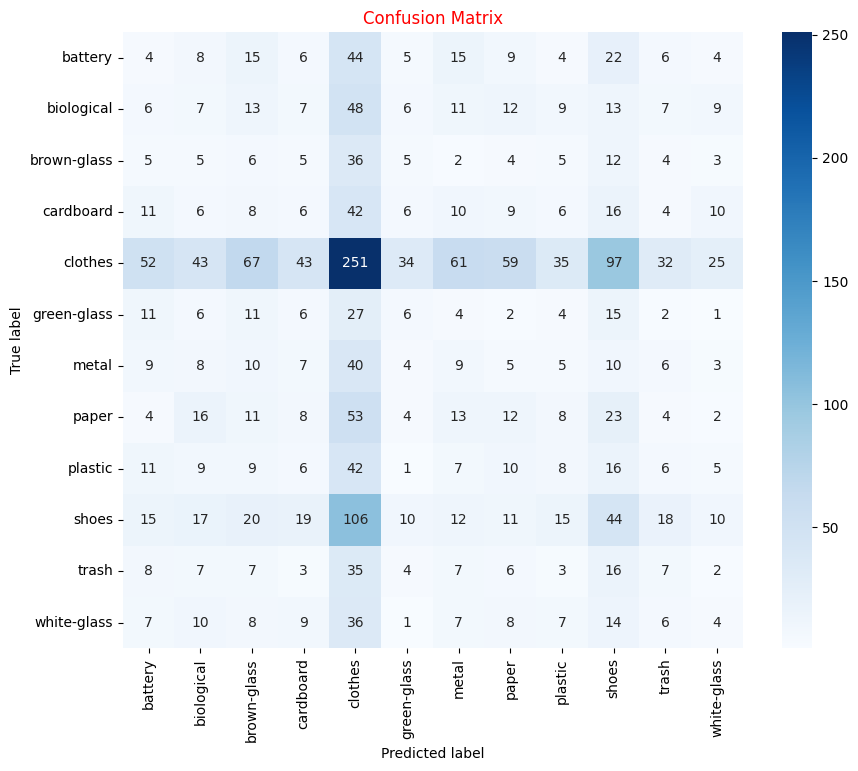

In [30]:
# now plotinng confusion matrix ...
# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# using seaborn for plooting .....
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix' , color = 'red')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [31]:
#saving model with name resnet medel vrsion 2
model.save("Resnet_modelv2_garbage_detection.keras")

In [33]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [36]:
import pickle

pickle.dump(model,open('model.pkl','wb'))

## model checking

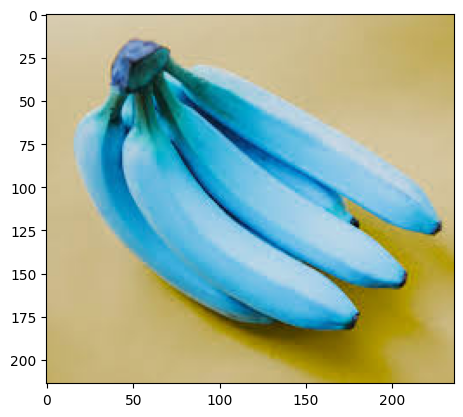

In [37]:
load_img = cv2.imread('/content/data/train/biological/biological1.jpg')
plt.imshow(load_img)

In [38]:
load_img.shape


(214, 236, 3)

In [41]:
load_img =cv2.resize(load_img ,(224, 224))
load_imput = load_img.reshape(1, 224, 224,3)

In [42]:
model.predict(load_imput)

1/1 [==============================] - 1s 878ms/step


array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

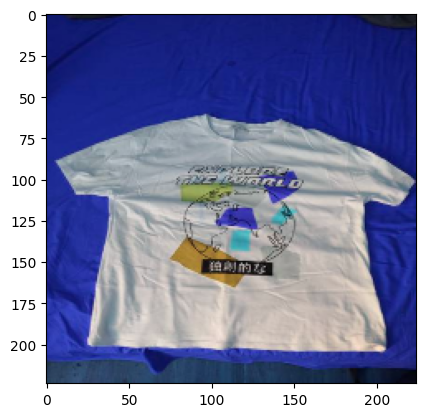

In [50]:
load_img2 = cv2.imread('/content/data/train/clothes/clothes1.jpg')
plt.imshow(load_img)

In [51]:
load_img2.shape

(534, 400, 3)

In [53]:
load_img2 =cv2.resize(load_img ,(224, 224))
load_input = load_img2.reshape(1, 224, 224,3)

In [54]:
model.predict(load_input)

1/1 [==============================] - 0s 84ms/step


array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)